In [1]:
import pickle
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.utils import shuffle
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score

from pandas.plotting import parallel_coordinates

class top_percentage_calculator():
    def __init__(self, reference_dict):
        self.reference_dict = reference_dict
        
    def calculate_top_percentage(self, value, target):
        if target in ["singlet-triplet value", "abs_diff_vee", "Er"]:
            counts = np.sum(self.reference_dict[target] <= value)
        elif target in ["oscillator strength", "Ea"]:
            counts = np.sum(self.reference_dict[target] >= value)
        percentage = (counts / len(self.reference_dict[target])) * 100
        return percentage

def sort_data_random(df):
    np.random.seed(0)
    df['random'] = np.random.random(size=len(df))
    sorted_df = df.sort_values(by=['fitness', 'random'], ascending=[False, True])
    sorted_df = sorted_df.drop(columns=['random'])
    return sorted_df

def calc_normalized_data(data, target_columns, scaler_dict):
    for target in target_columns:
        mean, std = scaler_dict[target]
        normalized_scores = [(s-mean)/std for s in data[target]]
        data["normalized "+target] = normalized_scores
    return data

def sample_data(sub_dir_name, target_columns, scaler_dict, cache_dict, num_fold, root_dir, sample_num):
    data_dict = {}
    for sub_dir in sub_dir_name:
        if sub_dir == "original data":
            continue
        smiles2fitness_dict = {}
        all_smiles_list = []
        for i in range(1, num_fold+1):
            smiles_list = []
            fitness_list = []
            dir_name = os.path.join(root_dir, sub_dir+"_"+str(i))
            with open(os.path.join(dir_name, "population_explore.txt"), "r") as f:
                smiles_list += f.read().strip().split(" ")
            with open(os.path.join(dir_name, "fitness_explore.txt"), "r") as f:
                fitness_list += f.read().strip().split(" ")
            with open(os.path.join(dir_name, "population_local_search.txt"), "r") as f:
                smiles_list += f.read().strip().split(" ")
            with open(os.path.join(dir_name, "fitness_local_search.txt"), "r") as f:
                fitness_list += f.read().strip().split(" ")
            fitness_list = [float(x) for x in fitness_list]
            for smiles, fitness in zip(smiles_list, fitness_list):
                smiles2fitness_dict.update({smiles: fitness})            
            smiles_fitness_data = list(zip(smiles_list, fitness_list))
            unique_data = set_and_sort(smiles_fitness_data)
            all_smiles_list += list(zip(*unique_data[:sample_num]))[0]
        data = pd.DataFrame(columns=target_columns)
        all_smiles_list = list(set(all_smiles_list))
        for smiles in all_smiles_list:
            scores = cache_dict.get(smiles)
            if scores:
                if abs(scores[0]) != 10000:
                    scores = list(scores)
                    data = pd.concat([data, pd.DataFrame([[smiles]+scores], columns=["smiles"]+target_columns)], axis=0)
                else:
                    score = float("nan")
        data = calc_normalized_data(data, target_columns, scaler_dict)
        data["fitness"] = [smiles2fitness_dict.get(smiles) for smiles in data["smiles"]]
        data_dict.update({sub_dir: sort_data_random(data).reset_index(drop=True)})
        
#         data_dict.update({sub_dir: data})
    return data_dict

def set_and_sort(data):
    seen_names = set()
    unique_data = []
    for name, score in data:
        if name not in seen_names:
            seen_names.add(name)
            unique_data.append((name, score))
    unique_data.sort(key=lambda x: x[1], reverse=True)
    return unique_data

def create3Dplot(sub_dir_name, data_dict, color_dict, target_columns, target_objective, cutoff_dict,
                purple_line_label="top-15% cutoff", top_num=50):
    target_name_dict = {"singlet-triplet value":"singlet-triplet value", "oscillator strength":"oscillator strength", 
                        "abs_diff_vee":"absolute difference of \n vertical excitation energy",}
    start_point = [cutoff_dict[target] for target in target_columns]  
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    for sub_dir in sub_dir_name:
        if sub_dir == "original data":
            continue
        data_dict.update({sub_dir: data_dict[sub_dir][:top_num]})
    
    extreme_point = [min(pd.concat([*data_dict.values()], axis=0)[target]) if target_objective[target]=="minimize" else max(pd.concat([*data_dict.values()], axis=0)[target]) for target in target_columns]
    end_x, end_y, end_z = extreme_point
    start_x, start_y, start_z = cutoff_dict[target_columns[0]], cutoff_dict[target_columns[1]], cutoff_dict[target_columns[2]]
    print(start_x, start_y, start_z)
    print(end_x, end_y, end_z)
    # 0.0116198315518392 0.9237570437583232 0.0023723931799306
    end_x = 0.0; end_y = 3.3; end_z = 0.0
#     start_x, end_x = min(start_x, end_x), max(start_x, end_x)
#     start_y, end_y = min(start_y, end_y), max(start_y, end_y)
#     start_z, end_z = min(start_z, end_z), max(start_z, end_z)
    
    for sub_dir in ["original data"] + sub_dir_name:
        data = data_dict[sub_dir]
        
        data_x = [x for x in data[target_columns[0]]] # normalized_target_columns
        data_y = [y for y in data[target_columns[1]]]
        data_z = [z for z in data[target_columns[2]]]
        if sub_dir in ["original data", "janus_utopian", "janus_hybrid"]:
            alpha = 0.15
        else:
            alpha = 0.6
        ax.scatter(data_x, data_y, data_z, c=color_dict[sub_dir], marker='o', label=sub_dir, alpha=alpha,s=9)

        
    vertices = [
        (start_x, start_y, start_z),
        (end_x, start_y, start_z),
        (start_x, end_y, start_z),
        (end_x, end_y, start_z),
        (start_x, start_y, end_z),
        (end_x, start_y, end_z),
        (start_x, end_y, end_z),
        (end_x, end_y, end_z)
    ]
    faces = [[vertices[0], vertices[1], vertices[3], vertices[2]],
            [vertices[4], vertices[5], vertices[7], vertices[6]],
            [vertices[0], vertices[1], vertices[5], vertices[4]],
            [vertices[2], vertices[3], vertices[7], vertices[6]],
            [vertices[0], vertices[2], vertices[6], vertices[4]],
            [vertices[1], vertices[3], vertices[7], vertices[5]]]
 
    ax.add_collection3d(Poly3DCollection(faces, facecolors='purple', linewidths=1, alpha=0.1))    
        
    ax.set_xlabel(target_name_dict[target_columns[0]]+"\n("+target_objective[target_columns[0]]+")", fontsize=10)
    ax.set_ylabel(target_name_dict[target_columns[1]]+"\n("+target_objective[target_columns[1]]+")", fontsize=10)
    ax.set_zlabel(target_name_dict[target_columns[2]]+"\n("+target_objective[target_columns[2]]+")", fontsize=10)
    
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2, 3])
    ax.set_zticks([0, 1, 2, 3, 4, 5, 6, 7])
    
    plt.legend(loc="upper right")
    plt.tight_layout()

def binary_conversion(value, cutoff, objective):
    if objective == "maximize":
        if value >= cutoff:
            return 1
        else:
            return 0
    elif objective == "minimize":
        if value <= cutoff:
            return 1
        else:
            return 0
    
def statistics_cutoffs(data, cutoff_dict, target_objective, target_columns, num_fold):
    pass_cutoff_num = [0]*(len(target_columns)+1) # np.zeros(len(target_columns)+1)
    
    sub_num = np.zeros(len(data))
    for target in target_columns:
        subdata = data[[target]]
        binary_df = subdata[[target]].astype(float).applymap(lambda x: binary_conversion(x, cutoff_dict[target], target_objective[target]))
        sub_num += binary_df.values.reshape(1,-1)[0]
    for x in sub_num:
        pass_cutoff_num[int(x)] += 1
    return pass_cutoff_num    

def create_cutoff_plot(data_dict, sub_dir_name, target_columns, target_objective, cutoff_dict, num_fold, color_dict,
                       bar_width = 0.3):
    plt.figure(dpi=100)
    x = np.arange(len(target_columns)+1)
    for i, sub_dir in enumerate(sub_dir_name):
        data = data_dict[sub_dir]
        heights = statistics_cutoffs(data, cutoff_dict, target_objective, target_columns, num_fold)
        plt.bar(x+ bar_width*i, heights, width=bar_width, label=sub_dir, color=color_dict[sub_dir])

    plt.legend()
    plt.ylabel("Number of molecules")
    plt.xlabel("Number of objectives passing the thresholds")
    plt.xticks(x + bar_width*(len(sub_dir_name)-1)/2, [str(z) for z in range(0, len(target_columns)+1)])
#     plt.savefig(os.path.join(save_dir, "cutoff_objectives"+".svg"), format='svg')

def pass_all_cutoffs_index(data, target_columns, target_objective, cutoff_dict, cache_dict, predict_dict):
    reference_founds = []
    reference_founds_index = []
    for j, smiles in enumerate(data["smiles"]): # data_dict['janus_scaler']["smiles"]
        reference_values = cache_dict[smiles]
        ref_rev_sum = 0
        for i, target in enumerate(target_columns):
            ref_rev_sum += 1 - binary_conversion(reference_values[i], cutoff_dict[target], target_objective[target])
        ref_positive = int(not bool(ref_rev_sum))
        if ref_positive:
            reference_founds_index.append(j)
        reference_founds.append(ref_positive)
    return data.iloc[reference_founds_index]

def is_pass_all_cutoffs(data, target_columns, target_objective, cutoff_dict, cache_dict, predict_dict):
    reference_founds = []
    predict_founds = []
    for smiles in data["smiles"]: # data_dict['janus_scaler']["smiles"]
        reference_values = cache_dict[smiles]
        predict_values = predict_dict[smiles]
        ref_rev_sum = 0
        pred_rev_sum = 0
        for i, target in enumerate(target_columns):
            ref_rev_sum += 1 - binary_conversion(reference_values[i], cutoff_dict[target], target_objective[target])
            pred_rev_sum += 1 - binary_conversion(predict_values[i], cutoff_dict[target], target_objective[target])
        ref_positive = int(not bool(ref_rev_sum))
        pred_positive = int(not bool(pred_rev_sum))
        reference_founds.append(ref_positive)
        predict_founds.append(pred_positive)
    return reference_founds, predict_founds

def create_confusion_matrix_plot(data_dict, method_list, target_columns, target_objective, cutoff_dict, cache_dict, predict_dict):
    for method in method_list:        
        reference_founds, predict_founds = is_pass_all_cutoffs(data_dict[method], target_columns, 
                                                               target_objective, cutoff_dict, cache_dict, predict_dict)
        print(method)
        print(reference_founds)
        print(predict_founds)
        print("precision:", precision_score(reference_founds, predict_founds))
        ConfusionMatrixDisplay.from_predictions(reference_founds, predict_founds, normalize="all")
    return

def create2Dplot(sub_dir_name, data_dict, color_dict, target_columns, target_objective, cutoff_dict,
                 purple_line_label="top-15% cutoff", top_num=50):
    target_name_dict = {"Ea": "activation energy", "Er": "reaction energy"}
    start_point = [cutoff_dict[target] for target in target_columns]
    normalized_target_columns = [target for target in target_columns]
        
    fig, ax = plt.subplots(dpi=150, figsize = (6, 6))
    for sub_dir in sub_dir_name:
        if sub_dir == "original data":
            continue
        data_dict.update({sub_dir: data_dict[sub_dir][:top_num]})
    extreme_point = [min(pd.concat([*data_dict.values()], axis=0)[target]) if target_objective[target]=="minimize" else max(pd.concat([*data_dict.values()], axis=0)[target]) for target in target_columns]
    for sub_dir in ["original data"] + sub_dir_name:
        data = data_dict[sub_dir]
        
        data_x = [x for x in data[normalized_target_columns[0]]]
        data_y = [y for y in data[normalized_target_columns[1]]]
        if sub_dir == "original data":
            alpha = 0.2
        else:
            alpha = 0.8
        ax.scatter(data_x, data_y, c=color_dict[sub_dir], marker='o', label=sub_dir, alpha=alpha,s=15,
                  linewidths=0.5, edgecolors="black")

    start_x, start_y = start_point
    end_x, end_y = extreme_point
    print(end_x, end_y)
    end_x += 3
    end_y -= 3
    ax.fill_between([start_x, end_x], [start_y, start_y], [end_y, end_y], color='purple', alpha=0.2, interpolate=True)
    
    ax.set_xlim(right=end_x)
    ax.set_ylim(bottom=end_y)
    ax.set_xlabel(target_name_dict[target_columns[0]]+"\n("+target_objective[target_columns[0]]+")",fontsize=12)
    ax.set_ylabel(target_name_dict[target_columns[1]]+"\n("+target_objective[target_columns[1]]+")",fontsize=12)
    plt.legend()
    plt.tight_layout()
    

def compute_precision(data_dict, method_list, target_columns, target_objective, cutoff_dict, cache_dict, predict_dict):
    for method in method_list:
        if method == "original data":
            continue
        reference_founds, predict_founds = is_pass_all_cutoffs(data_dict[method], target_columns, 
                                                               target_objective, cutoff_dict, cache_dict, predict_dict)
        print(method)
        print("precision:", precision_score(reference_founds, predict_founds))
    return

def compute_hit_rate(benchmark_dict, method_list, target_cutoff, target_objective, top_list=[10,50,100]):
    for top_num in top_list:
        for method in method_list:
            sub_data = benchmark_dict[method].dropna()[:top_num]
            for target, objective in target_objective.items():
                cutoff = target_cutoff[target]
                if objective == "maximize":
                    sub_data = sub_data[sub_data[target] >= cutoff]
                elif objective == "minimize":
                    sub_data = sub_data[sub_data[target] <= cutoff]
            found = len(sub_data)
            print(f"{method}, top-{top_num} hit rate: {found/top_num*100}%")

### Organic Emitter

original data, top-10 hit rate: 0.0%
janus_scaler, top-10 hit rate: 0.0%
janus_utopian, top-10 hit rate: 30.0%
janus_hybrid, top-10 hit rate: 0.0%
janus_uncertainty, top-10 hit rate: 80.0%
original data, top-50 hit rate: 0.0%
janus_scaler, top-50 hit rate: 0.0%
janus_utopian, top-50 hit rate: 38.0%
janus_hybrid, top-50 hit rate: 20.0%
janus_uncertainty, top-50 hit rate: 56.00000000000001%
original data, top-100 hit rate: 0.0%
janus_scaler, top-100 hit rate: 0.0%
janus_utopian, top-100 hit rate: 35.0%
janus_hybrid, top-100 hit rate: 28.999999999999996%
janus_uncertainty, top-100 hit rate: 36.0%
S And E
[0.1706886, 0.57068] [3.0453214779843414, 0.0197837099745624]
3.3327847657827756 0.07487333897710616
S And E
[0.57068, 1.615238] [0.0197837099745624, 0.4404144541564662]
-0.035305919027981365 0.5578968087408196
S And E
[0.1706886, 1.615238] [3.0453214779843414, 0.4404144541564662]
3.3327847657827756 0.5578968087408196


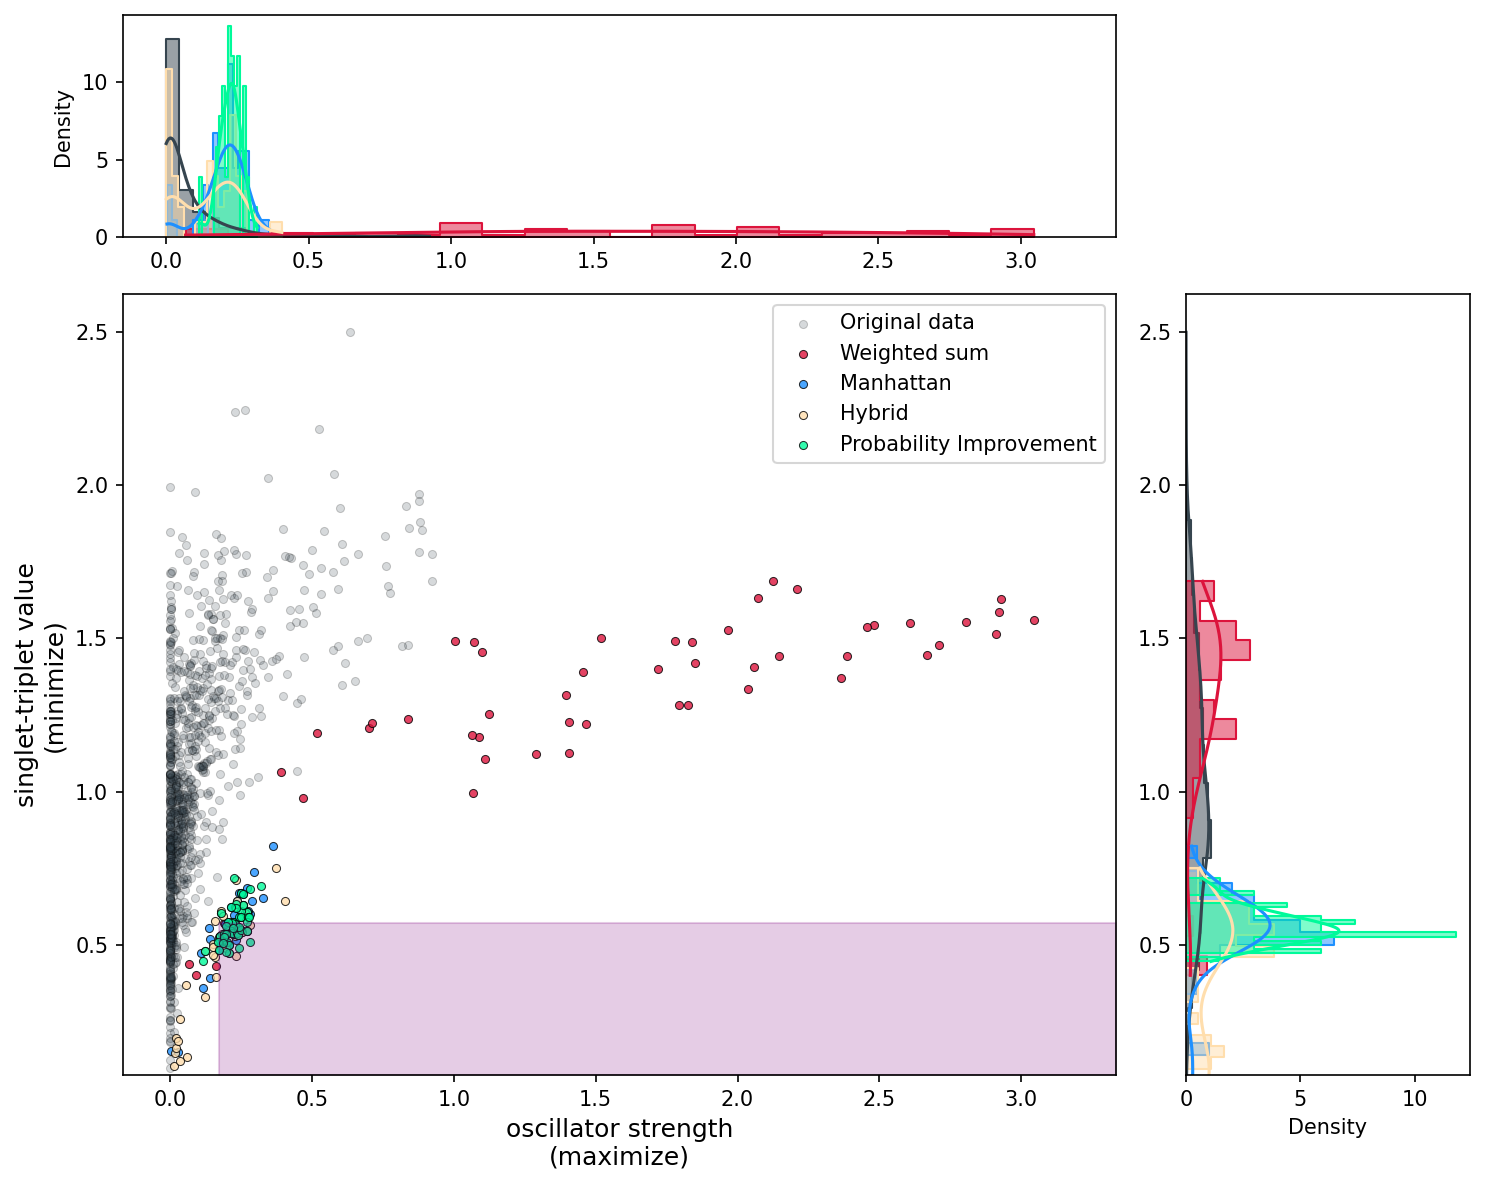

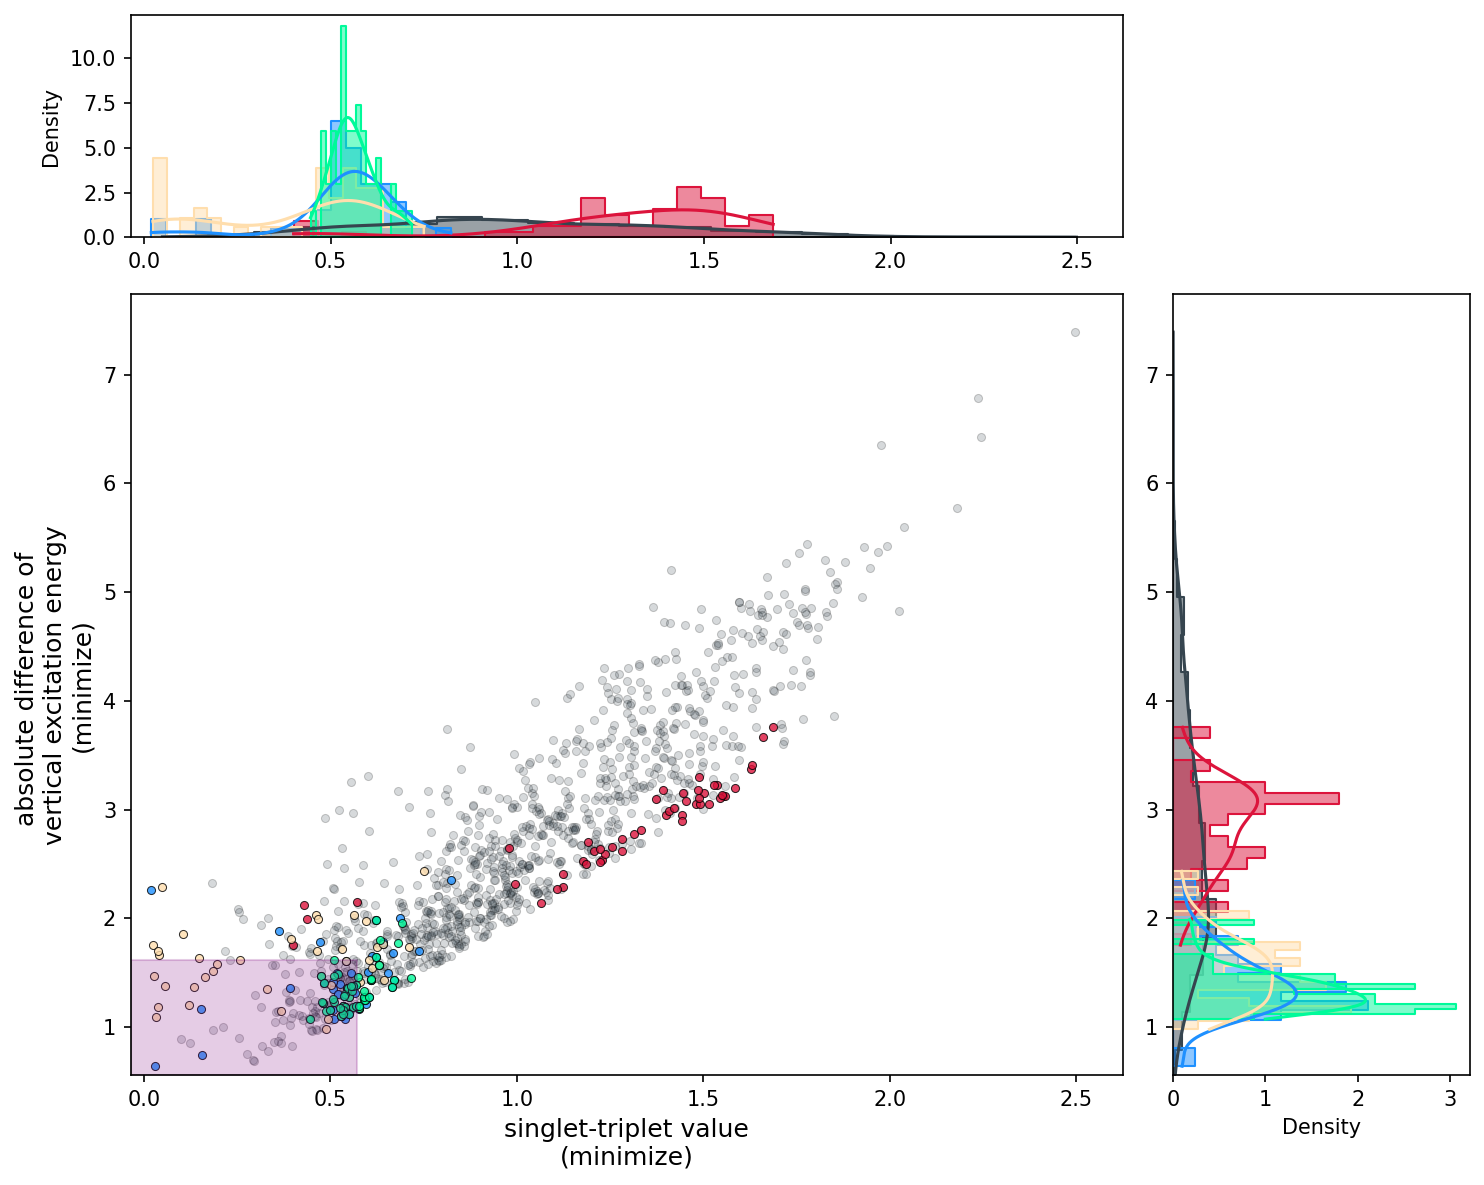

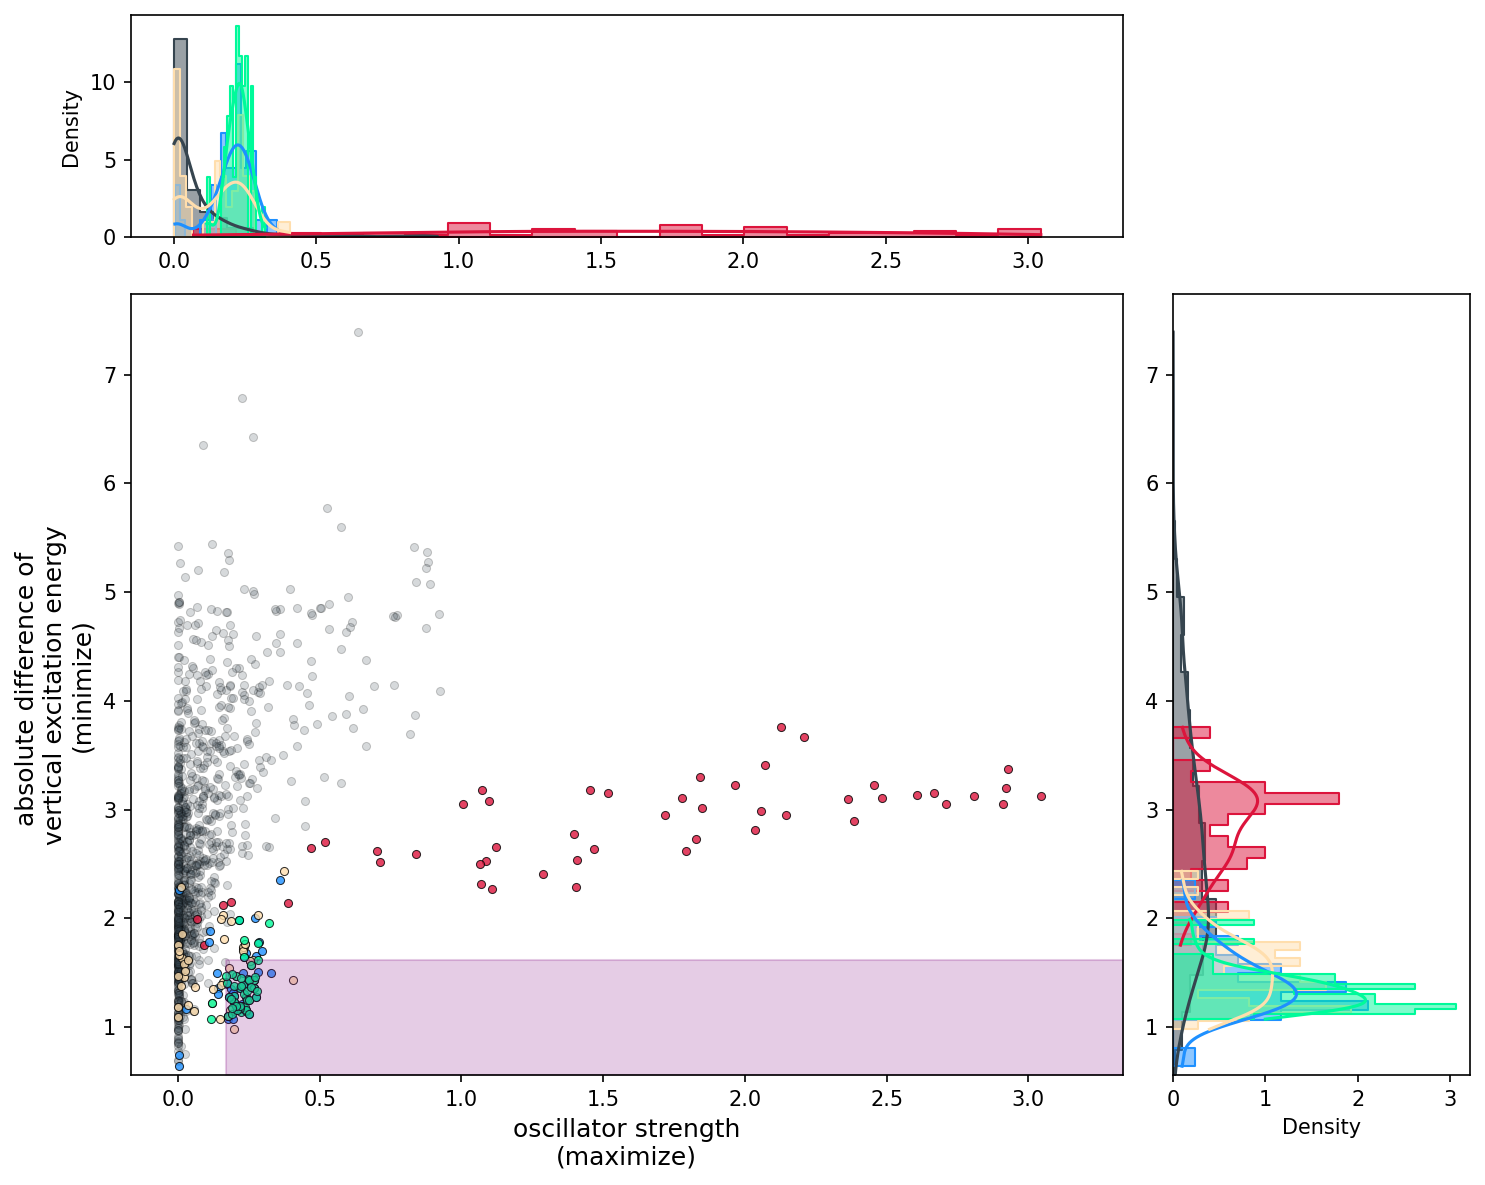

In [2]:
def create2Dplot_with_dist(sub_dir_name, data_dict, color_dict, target_columns, target_objective, cutoff_dict,
                 purple_line_label="top-15% cutoff", top_num=50, legend=False):
    #### This function would make the data_dict truncated to the number of (top_num) data points. ###
    target_name_dict = {"Ea": "activation energy", "Er": "reaction energy","singlet-triplet value":"singlet-triplet value", 
                        "oscillator strength":"oscillator strength", "abs_diff_vee":"absolute difference of \nvertical excitation energy"}
    start_point = [cutoff_dict[target] for target in target_columns]
    normalized_target_columns = [target for target in target_columns]
        
    fig = plt.subplots(dpi=150, figsize = (10, 8))
    ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)
    ax_histx = plt.subplot2grid((4, 4), (0, 0), colspan=3)
    ax_histy = plt.subplot2grid((4, 4), (1, 3), rowspan=3)
    
    for sub_dir in sub_dir_name:
        if sub_dir == "original data":
            continue
        data_dict.update({sub_dir: data_dict[sub_dir][:top_num]})
    extreme_point = [min(pd.concat([*data_dict.values()], axis=0)[target]) if target_objective[target]=="minimize" 
                     else max(pd.concat([*data_dict.values()], axis=0)[target]) for target in target_columns]
    all_data_x = []
    all_data_y = []
    all_labels = []
    all_colors = []
    for sub_dir in sub_dir_name:
        data = data_dict[sub_dir]
        data_x = [x for x in data[normalized_target_columns[0]]]
        data_y = [y for y in data[normalized_target_columns[1]]]
        all_data_x += data_x
        all_data_y += data_y
        all_labels += [sub_dir]*len(data_x)
        all_colors += [color_dict[sub_dir]]*len(data_x)
        if sub_dir == "original data":
            alpha = 0.2
        else:
            alpha = 0.8
    
    all_data = pd.DataFrame({"x":all_data_x, "y":all_data_y, "label":all_labels, "color":all_colors})
    for sub_dir in sub_dir_name:
        sns.histplot(all_data[all_data["label"]==sub_dir], x="x", bins=20, ax=ax_histx, color=color_dict[sub_dir],#hue="label", palette=color_dict,
                     kde=True, element='step', stat='density', legend=False)
        sns.histplot(all_data[all_data["label"]==sub_dir], y="y", bins=20, ax=ax_histy, color=color_dict[sub_dir],#hue="label", palette=color_dict,
                     kde=True, element='step', stat='density', legend=False)
#     ax_histx.set_xticks([])
    ax_histx.set_xlabel(None)
#     ax_histy.set_yticks([])
    ax_histy.set_ylabel(None)

    
    for sub_dir in sub_dir_name:
        if sub_dir == "original data":
            alpha = 0.2
        else:
            alpha = 0.8
        ax_scatter.scatter(all_data[all_data["label"]==sub_dir]["x"], all_data[all_data["label"]==sub_dir]["y"], 
                       c=color_dict[sub_dir], marker='o', alpha=alpha ,s=15, linewidths=0.5, edgecolors="black")
    if legend:
        ax_scatter.legend(["Original data","Weighted sum","Manhattan", "Hybrid", "Probability Improvement"])
    
    start_x, start_y = start_point
    end_x, end_y = extreme_point
    
    end_x += (end_x - start_x)*0.1
    end_y -= (end_y - start_y)*0.1
    print("S And E")
    print(start_point, extreme_point)
    print(end_x, end_y)
    
    ax_scatter.fill_between([start_x, end_x], [start_y, start_y], [end_y, end_y], color='purple', alpha=0.2, interpolate=True)
    if target_objective[target_columns[0]] == "maximize":
        ax_scatter.set_xlim(right=end_x)
        ax_histx.set_xlim(right=end_x)
    else:
        ax_scatter.set_xlim(left=end_x)
        ax_histx.set_xlim(left=end_x)
    if target_objective[target_columns[1]] == "maximize":
        ax_scatter.set_ylim(top=end_y)
        ax_histy.set_ylim(top=end_y)
    else:
        ax_scatter.set_ylim(bottom=end_y)
        ax_histy.set_ylim(bottom=end_y)
    ax_scatter.set_xlabel(target_name_dict[target_columns[0]]+"\n("+target_objective[target_columns[0]]+")",fontsize=12)
    ax_scatter.set_ylabel(target_name_dict[target_columns[1]]+"\n("+target_objective[target_columns[1]]+")",fontsize=12)
    
    plt.tight_layout()

data_set = "organic_emitter" 
data_path = "../Tartarus/datasets/gdb13.csv"
root_dir = "../RESULTS/{}".format(data_set)
cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)

""" The singlet-triplet value shoulb time minus one !!! """
for smiles, target_values in predict_dict.items():
    stv, osv, mov = target_values
    predict_dict[smiles] = (-stv, osv, mov)
    
sub_dir_name = ["original data", "janus_scaler","janus_utopian", "janus_hybrid", "janus_uncertainty"]
target_columns = ["singlet-triplet value", "oscillator strength", "abs_diff_vee"]
scaler_dict = {"singlet-triplet value": (1.003, 0.396), "oscillator strength": (0.086, 0.149), "abs_diff_vee": (2.688, 1.038),}

# top-15% cutoff
cutoff_dict = {"singlet-triplet value":0.57068, "oscillator strength":0.1706886, "abs_diff_vee": 1.615238}

target_objective = {"singlet-triplet value":"minimize", 
                    "oscillator strength":"maximize", 
                    "abs_diff_vee":"minimize"}

# color_dict = {"original data": "black", "janus_scaler":"red", "janus_hybrid":"orange", "janus_uncertainty":"green", "janus_utopian":"blue"}
color_dict = {"original data": "#36454F", "janus_scaler":"crimson", "janus_hybrid":"navajowhite",
              "janus_uncertainty":"mediumspringgreen", "janus_utopian":"dodgerblue"}
num_fold = 15
normalized_cutoff_dict = { key: (value-scaler_dict[key][0])/scaler_dict[key][1] for key, value in cutoff_dict.items() }


data = pd.read_csv(data_path)
data["singlet-triplet value"] = data["singlet-triplet value"]
data = shuffle(calc_normalized_data(data, target_columns, scaler_dict),random_state=13)[:1000]
data_dict = sample_data(sub_dir_name, target_columns, scaler_dict, cache_dict, num_fold, root_dir,sample_num=-1)
data_dict.update({"original data": data})

compute_hit_rate(data_dict, sub_dir_name, cutoff_dict, target_objective, top_list=[10,50,100])

create2Dplot_with_dist(sub_dir_name, data_dict, color_dict, ["oscillator strength", "singlet-triplet value"], target_objective, cutoff_dict,top_num=50,purple_line_label="top-15% cutoff",legend=True)
create2Dplot_with_dist(sub_dir_name, data_dict, color_dict, ["singlet-triplet value", "abs_diff_vee"], target_objective, cutoff_dict,top_num=50,purple_line_label="top-15% cutoff")
create2Dplot_with_dist(sub_dir_name, data_dict, color_dict, ["oscillator strength", "abs_diff_vee"], target_objective, cutoff_dict,top_num=50,purple_line_label="top-15% cutoff")

combined_data_dict = {key: value.drop(columns="smiles") for key, value in data_dict.items()}

In [ ]:
data_path = "../Tartarus/datasets/gdb13.csv"
data = pd.read_csv(data_path)
reference_dict = {"singlet-triplet value": np.array(data["singlet-triplet value"]),
                  "oscillator strength": np.array(data["oscillator strength"]),
                  "abs_diff_vee": np.array(data["abs_diff_vee"])}
tpc = top_percentage_calculator(reference_dict)
for target in ["singlet-triplet value", "oscillator strength", "abs_diff_vee"]:
    for method in ["janus_scaler","janus_utopian", "janus_hybrid", "janus_uncertainty"]:
        data_dict[method][target + " top%"] = [tpc.calculate_top_percentage(x, target) for x in data_dict[method][target]]

# Sample data for two types of 3D data points
data_type1 = {
    'Feature1': data_dict["janus_scaler"]["singlet-triplet value top%"][:50],
    'Feature2': data_dict["janus_scaler"]["oscillator strength top%"][:50],
    'Feature3': data_dict["janus_scaler"]["abs_diff_vee top%"][:50],
    'Type': ['WS'] * 50
}

data_type2 = {
    'Feature1': data_dict["janus_utopian"]["singlet-triplet value top%"][:50],
    'Feature2': data_dict["janus_utopian"]["oscillator strength top%"][:50],
    'Feature3': data_dict["janus_utopian"]["abs_diff_vee top%"][:50],
    'Type': ['NMD'] * 50
}

data_type3 = {
    'Feature1': data_dict["janus_hybrid"]["singlet-triplet value top%"][:50],
    'Feature2': data_dict["janus_hybrid"]["oscillator strength top%"][:50],
    'Feature3': data_dict["janus_hybrid"]["abs_diff_vee top%"][:50],
    'Type': ['WS-NMD'] * 50
}

data_type4 = {
    'Feature1': data_dict["janus_uncertainty"]["singlet-triplet value top%"][:50],
    'Feature2': data_dict["janus_uncertainty"]["oscillator strength top%"][:50],
    'Feature3': data_dict["janus_uncertainty"]["abs_diff_vee top%"][:50],
    'Type': ['PIO'] * 50
}

# Create DataFrame
df_type1 = pd.DataFrame(data_type1)
df_type2 = pd.DataFrame(data_type2)
df_type3 = pd.DataFrame(data_type3)
df_type4 = pd.DataFrame(data_type4)
df = pd.concat([df_type1, df_type2, df_type3, df_type4])

# Plotting Parallel Coordinates Plot
plt.figure(figsize=(10, 6))
pc = parallel_coordinates(df, 'Type', color=['crimson', 'dodgerblue', 'navajowhite', 'mediumspringgreen'], )
color_dict = {"original data": "#36454F", "janus_scaler":"crimson", "janus_hybrid":"navajowhite",
              "janus_uncertainty":"mediumspringgreen", "janus_utopian":"dodgerblue"}
plt.title('Parallel Coordinates Plot')
new_feature_names = ['Singlet-triplet gap', 'Oscillator strength', 'Absolute difference of \nvertical excitation energy']
plt.xticks(range(len(new_feature_names)), new_feature_names)
for line in pc.get_lines():
    line.set_linewidth(0.4)  # Adjust the linewidth as desired
# plt.legend(['janus_scaler', 'janus_uncertainty'])
# Add purple shaded region for y between 0 and 3
for i in range(len(new_feature_names) - 1):
    plt.fill_between([i, i + 1], 0, 15, color='purple', alpha=0.2)
plt.show()

In [ ]:
data_path = "../Tartarus/datasets/gdb13.csv"
data = pd.read_csv(data_path)
reference_dict = {"singlet-triplet value": np.array(data["singlet-triplet value"]),
                  "oscillator strength": np.array(data["oscillator strength"]),
                  "abs_diff_vee": np.array(data["abs_diff_vee"])}
name_dict = {"original data": "original data", "janus_scaler":"WS", "janus_hybrid":"NMD-WS",
                  "janus_uncertainty":"PIO", "janus_utopian":"NMD"}
tpc = top_percentage_calculator(reference_dict)
for target in ["singlet-triplet value", "oscillator strength", "abs_diff_vee"]:
    for method in ["janus_scaler","janus_utopian", "janus_hybrid", "janus_uncertainty"]:
        data_dict[method][target + " top%"] = [tpc.calculate_top_percentage(x, target) for x in data_dict[method][target]]

for method in ["janus_scaler","janus_utopian", "janus_hybrid", "janus_uncertainty"]:
    # Sample data for two types of 3D data points
    data_type1 = {
        'Feature1': data_dict[method]["singlet-triplet value top%"][:50],
        'Feature2': data_dict[method]["oscillator strength top%"][:50],
        'Feature3': data_dict[method]["abs_diff_vee top%"][:50],
        'Type': [name_dict[method]] * 50
    }

    # Create DataFrame
    df = pd.DataFrame(data_type1)

    # Plotting Parallel Coordinates Plot
    plt.figure(figsize=(10, 6))
    color_dict = {"original data": "#36454F", "janus_scaler":"crimson", "janus_hybrid":"navajowhite",
                  "janus_uncertainty":"mediumspringgreen", "janus_utopian":"dodgerblue"}
    for i in range(len(new_feature_names) - 1):
        plt.fill_between([i, i + 1], 0, 15, color='purple', alpha=0.3, linewidth=0.1, edgecolor='black')
    pc = parallel_coordinates(df, 'Type', color=[color_dict[method]], )
    plt.title('Parallel Coordinates Plot')
    new_feature_names = ['Singlet-triplet gap', 'Oscillator strength', 'Absolute difference of \nvertical excitation energy']
    plt.xticks(range(len(new_feature_names)), new_feature_names)
    plt.ylim(0, 100)
    plt.yticks([0, 20, 40, 60, 80, 100])
    for line in pc.get_lines():
        line.set_linewidth(1)  # Adjust the linewidth as desired
    # plt.legend(['janus_scaler', 'janus_uncertainty'])
    # Add purple shaded region for y between 0 and 3

    plt.show()

In [ ]:
data_path = "../Tartarus/datasets/gdb13.csv"
data = pd.read_csv(data_path)

new_feature_names = ['Singlet-triplet\ngap', 'Oscillator strength', 'Absolute difference\nof vertical\nexcitation energy']
reference_dict = {"singlet-triplet value": np.array(data["singlet-triplet value"]),
                  "oscillator strength": np.array(data["oscillator strength"]),
                  "abs_diff_vee": np.array(data["abs_diff_vee"])}
name_dict = {"original data": "original data", "janus_scaler":"WS", "janus_hybrid":"NMD-WS",
                  "janus_uncertainty":"PIO", "janus_utopian":"NMD"}
tpc = top_percentage_calculator(reference_dict)
for target in ["singlet-triplet value", "oscillator strength", "abs_diff_vee"]:
    for method in ["janus_scaler","janus_utopian", "janus_hybrid", "janus_uncertainty"]:
        data_dict[method][target + " top%"] = [tpc.calculate_top_percentage(x, target) for x in data_dict[method][target]]

plt.subplots(2, 2, figsize=(18, 12))
for k, method in enumerate(["janus_scaler","janus_utopian", "janus_hybrid", "janus_uncertainty"]):
    # Sample data for two types of 3D data points
    subdata = data_dict[method][:50]
    subdata_pass = subdata[subdata["singlet-triplet value top%"] <= 15]
    subdata_pass = subdata_pass[subdata_pass["oscillator strength top%"] <= 15]
    subdata_pass = subdata_pass[subdata_pass["abs_diff_vee top%"] <= 15]
    subdata_fail = subdata.drop(subdata_pass.index)
    data_type0 = {
        'Feature1': subdata_fail["singlet-triplet value top%"],
        'Feature2': subdata_fail["oscillator strength top%"],
        'Feature3': subdata_fail["abs_diff_vee top%"],
        'Type': ["Failed"] * len(subdata_fail)
    }
    data_type1 = {
        'Feature1': subdata_pass["singlet-triplet value top%"],
        'Feature2': subdata_pass["oscillator strength top%"],
        'Feature3': subdata_pass["abs_diff_vee top%"],
        'Type': ["Successful"] * len(subdata_pass)
    }
    

    # Create DataFrame
    df_type1 = pd.DataFrame(data_type1)
    df_type0 = pd.DataFrame(data_type0)
    df = pd.concat([df_type0, df_type1])

    # Plotting Parallel Coordinates Plot
    plt.subplot(f"22{k+1}")
    color_dict = {"original data": "#36454F", "janus_scaler":"crimson", "janus_hybrid":"navajowhite",
                  "janus_uncertainty":"mediumspringgreen", "janus_utopian":"dodgerblue"}
    for i in range(len(new_feature_names) - 1):
        plt.fill_between([i, i + 1], 0, 15, color='purple', alpha=0.3, linewidth=0.1, edgecolor='black')
    pc = parallel_coordinates(df, 'Type', color=["#2980B9", "#F39C12"], )
    plt.title(name_dict[method], fontsize=22)
    plt.legend(fontsize=17)
    if k in [2, 3]:
        plt.xticks(range(len(new_feature_names)), new_feature_names, fontsize=16)
    else:
        plt.xticks([])
    plt.ylim(0, 100)
    plt.yticks([0, 20, 40, 60, 80, 100], fontsize=14)
    if k in [0, 2]:
        plt.ylabel("Top percentile values\nbased on original dataset", fontsize=16)
    for line in pc.get_lines():
        line.set_linewidth(1)  # Adjust the linewidth as desired
    plt.tight_layout()
# plt.savefig(str(k+1)+name_dict[method]+".svg", format="svg")
plt.savefig("all.svg", format="svg")
plt.show()

### Reaction substrate design (reactivity)

original data, top-10 hit rate: 0.0%
janus_scaler, top-10 hit rate: 20.0%
janus_utopian, top-10 hit rate: 20.0%
janus_hybrid, top-10 hit rate: 40.0%
janus_uncertainty, top-10 hit rate: 40.0%
original data, top-50 hit rate: 0.0%
janus_scaler, top-50 hit rate: 8.0%
janus_utopian, top-50 hit rate: 14.000000000000002%
janus_hybrid, top-50 hit rate: 16.0%
janus_uncertainty, top-50 hit rate: 22.0%
original data, top-100 hit rate: 0.0%
janus_scaler, top-100 hit rate: 7.000000000000001%
janus_utopian, top-100 hit rate: 12.0%
janus_hybrid, top-100 hit rate: 11.0%
janus_uncertainty, top-100 hit rate: 22.0%
S And E
[86.96834, -5.46226] [110.0901632476412, -19.98403267991017]
112.40234557240532 -18.531855411919153


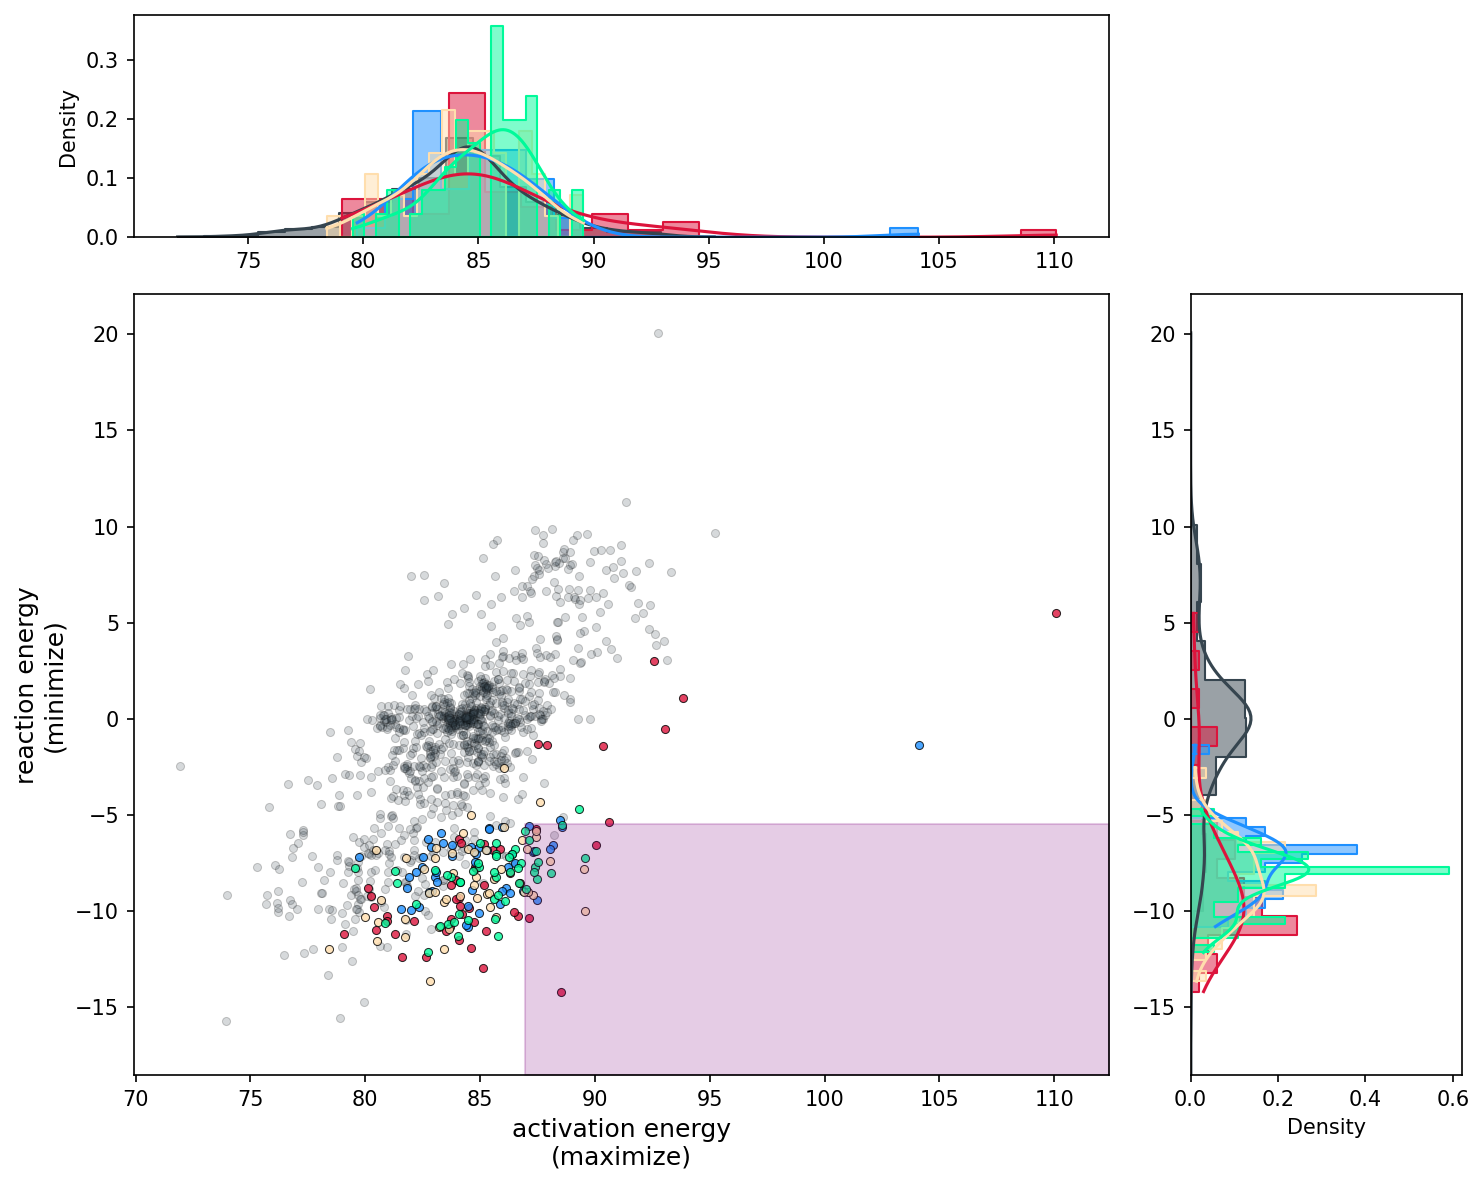

In [3]:
num_samples_in_each_fold = 15

data_set = "reactivity" # 
data_path = "../Tartarus/datasets/reactivity.csv"
root_dir = "../RESULTS/{}".format(data_set)
cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["original data", "janus_scaler","janus_utopian", "janus_hybrid", "janus_uncertainty"]
target_columns = ["Ea", "Er",]
scaler_dict = {"Ea": (84.104, 3.076), "Er": (-0.749, 4.507),}
# top-12.5%
# cutoff_dict = {"Ea": 87.3226545, "Er": -6.41327,}
# top-15%
cutoff_dict = {"Ea": 86.96834, "Er": -5.46226,} 
target_objective = {"Ea":"maximize", 
                    "Er":"minimize",}
# color_dict = {"original data": "black", "janus_scaler":"red", "janus_hybrid":"orange", "janus_uncertainty":"green", "janus_utopian":"blue"}
color_dict = {"original data": "#36454F", "janus_scaler":"crimson", "janus_hybrid":"navajowhite",
              "janus_uncertainty":"mediumspringgreen", "janus_utopian":"dodgerblue"}
num_fold = 15


data = pd.read_csv(data_path)
data = shuffle(calc_normalized_data(data, target_columns, scaler_dict),random_state=12)[:1000]
data_dict = sample_data(sub_dir_name, target_columns, scaler_dict, cache_dict, num_fold, root_dir,sample_num=-1)
data_dict.update({"original data": data})

compute_hit_rate(data_dict, sub_dir_name, cutoff_dict, target_objective, top_list=[10,50,100])
create2Dplot_with_dist(sub_dir_name, data_dict, color_dict, target_columns, target_objective, cutoff_dict,top_num=50,purple_line_label="top-15% cutoff")

for key, value in data_dict.items():
    combined_data_dict[key] = pd.concat([combined_data_dict[key], value.drop(columns="smiles")], axis=1)

# Parallel Coordinates Plot for these two multi-objective tasks 

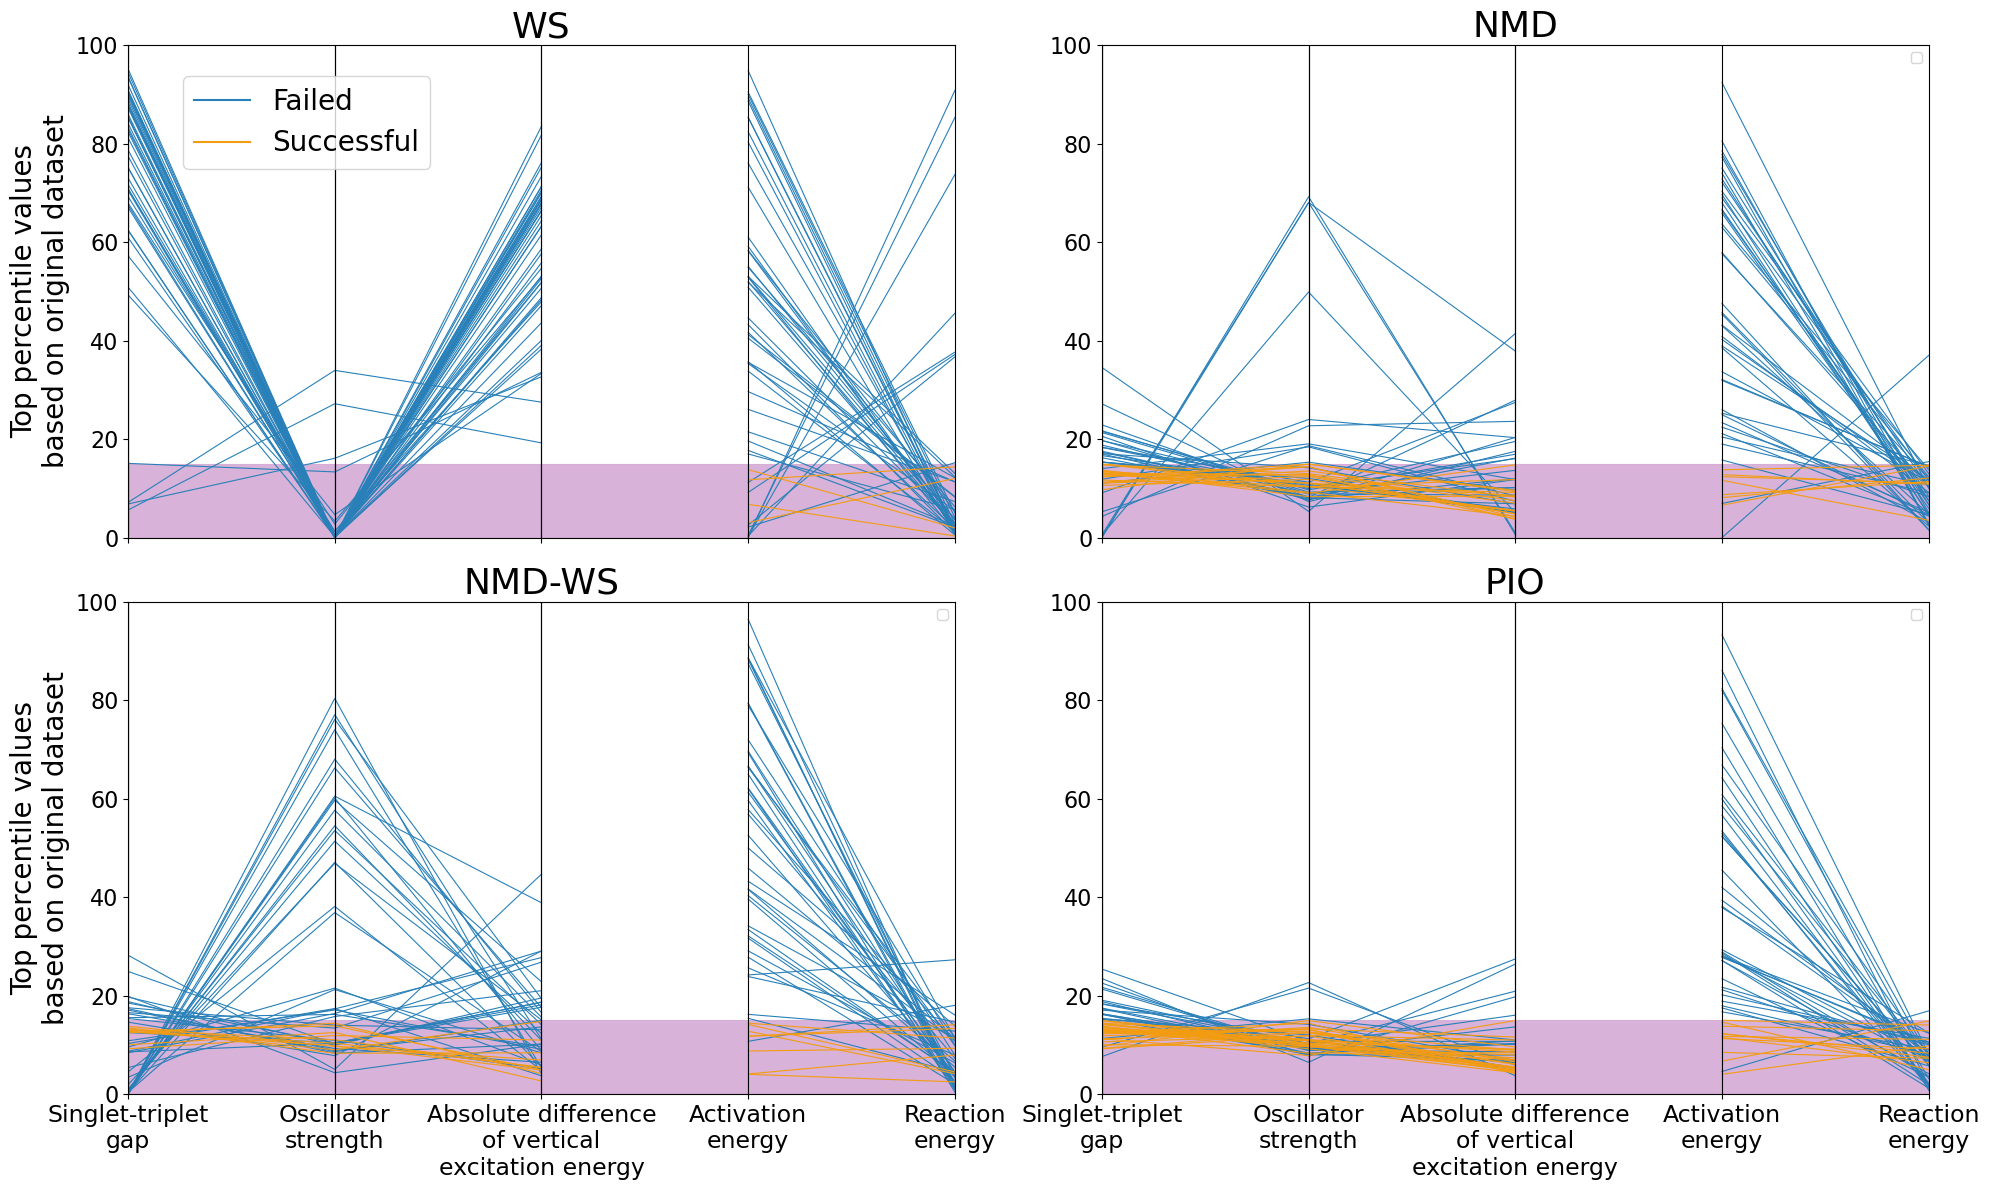

In [20]:
from pandas.plotting import parallel_coordinates

# Organic emitter
data_path = "../Tartarus/datasets/gdb13.csv"
data = pd.read_csv(data_path)
reference_dict = {"singlet-triplet value": np.array(data["singlet-triplet value"]),
                  "oscillator strength": np.array(data["oscillator strength"]),
                  "abs_diff_vee": np.array(data["abs_diff_vee"])}
tpc = top_percentage_calculator(reference_dict)
for target in ["singlet-triplet value", "oscillator strength", "abs_diff_vee"]:
    for method in ["janus_scaler","janus_utopian", "janus_hybrid", "janus_uncertainty"]:
        combined_data_dict[method][target + " top%"] = [tpc.calculate_top_percentage(x, target) for x in combined_data_dict[method][target]]

# Reactivity
data_path = "../Tartarus/datasets/reactivity.csv"
data = pd.read_csv(data_path)
reference_dict = {"Ea": np.array(data["Ea"]),
                  "Er": np.array(data["Er"]),}
tpc = top_percentage_calculator(reference_dict)
for target in ["Ea", "Er"]:
    for method in ["janus_scaler","janus_utopian", "janus_hybrid", "janus_uncertainty"]:
        combined_data_dict[method][target + " top%"] = [tpc.calculate_top_percentage(x, target) for x in combined_data_dict[method][target]]
        
new_feature_names = ['Singlet-triplet\ngap', 'Oscillator\nstrength', 'Absolute difference\nof vertical\nexcitation energy',
                     'Activation\nenergy', 'Reaction\nenergy']
name_dict = {"original data": "original data", "janus_scaler":"WS", "janus_hybrid":"NMD-WS",
                  "janus_uncertainty":"PIO", "janus_utopian":"NMD"}
plt.subplots(2, 2, figsize=(20, 12))
for k, method in enumerate(["janus_scaler","janus_utopian", "janus_hybrid", "janus_uncertainty"]):
    # Sample data for two types of 3D data points
    subdata = combined_data_dict[method][:50]
    subdata_oe_pass = subdata[subdata["singlet-triplet value top%"] <= 15]
    subdata_oe_pass = subdata_oe_pass[subdata_oe_pass["oscillator strength top%"] <= 15]
    subdata_oe_pass = subdata_oe_pass[subdata_oe_pass["abs_diff_vee top%"] <= 15]
    subdata_oe_fail = subdata.drop(subdata_oe_pass.index)
    
    subdata_rea_pass = subdata[subdata["Ea top%"] <= 15]
    subdata_rea_pass = subdata_rea_pass[subdata_rea_pass["Er top%"] <= 15]
    subdata_rea_fail = subdata.drop(subdata_rea_pass.index)
    
    data_type0_part1 = {
        'Feature1': subdata_oe_fail["singlet-triplet value top%"],
        'Feature2': subdata_oe_fail["oscillator strength top%"],
        'Feature3': subdata_oe_fail["abs_diff_vee top%"],
        'Type': ["Failed"] * len(subdata_oe_fail)
    }
    data_type0_part2 = {
        'Feature4': subdata_rea_fail["Ea top%"],
        'Feature5': subdata_rea_fail["Er top%"],
        'Type': ["Failed"] * len(subdata_rea_fail)
    }
    data_type1_part1 = {
        'Feature1': subdata_oe_pass["singlet-triplet value top%"],
        'Feature2': subdata_oe_pass["oscillator strength top%"],
        'Feature3': subdata_oe_pass["abs_diff_vee top%"],
        'Type': ["Successful"] * len(subdata_oe_pass)
    }
    data_type1_part2 = {
        'Feature4': subdata_rea_pass["Ea top%"],
        'Feature5': subdata_rea_pass["Er top%"],
        'Type': ["Successful"] * len(subdata_rea_pass)
    }
    
    # Create DataFrame
    df_type0_part2 = pd.DataFrame(data_type0_part2)
    df_type0_part1 = pd.DataFrame(data_type0_part1)
    df_type1_part2 = pd.DataFrame(data_type1_part2)
    df_type1_part1 = pd.DataFrame(data_type1_part1)
#     print(len(df_type0_part2))
    
    df_type0_part2 = df_type0_part2.reindex(range(50)).reset_index(drop=True)
    df_type0_combined = pd.concat([df_type0_part1, df_type0_part2], axis=1)
    df_type1_part2 = df_type1_part2.reindex(range(50)).reset_index(drop=True)
    df_type1_combined = pd.concat([df_type1_part1, df_type1_part2], axis=1)

    # Plotting Parallel Coordinates Plot
    plt.subplot(f"22{k+1}")

    for i in range(len(new_feature_names) - 1):
        plt.fill_between([i, i + 1], 0, 15, color='purple', alpha=0.3, linewidth=0.1, edgecolor='black')

    # Plot part 1
    pc = parallel_coordinates(df_type0_part1, 'Type', color='#2980B9')
    # Manually plot part 2
    for i in range(len(df_type0_part2)):
        plt.plot([3, 4], [df_type0_combined['Feature4'][i], df_type0_combined['Feature5'][i]], color='#2980B9')
    # Plot part 1
    pc = parallel_coordinates(df_type1_part1, 'Type', color='#F39C12')
    # Manually plot part 2
    for i in range(len(df_type1_part2)):
        if i == 0:
            plt.plot([3, 4], [df_type1_combined['Feature4'][i], df_type1_combined['Feature5'][i]], color='#F39C12', label="Successful")
        else:
            plt.plot([3, 4], [df_type1_combined['Feature4'][i], df_type1_combined['Feature5'][i]], color='#F39C12')
    plt.axvline(x=3, color='black', linestyle='-', linewidth=1) 

    
    plt.title(name_dict[method], fontsize=26)
    if k == 0:
        plt.legend(bbox_to_anchor=[0.05, 0.965], fontsize=20)
    else:
        plt.legend([])
    if k in [2, 3]:
        plt.xticks(range(len(new_feature_names)), new_feature_names, fontsize=17)
    else:
        plt.xticks(range(len(new_feature_names)), [None]*5)
    plt.ylim(0, 100)
    plt.yticks([0, 20, 40, 60, 80, 100], fontsize=16)
    if k in [0, 2]:
        plt.ylabel("Top percentile values\nbased on original dataset", fontsize=20)
    for line in pc.get_lines():
        line.set_linewidth(0.8)  # Adjust the linewidth as desired
    plt.tight_layout()

plt.savefig("all2.svg", format="svg")
plt.show()

WS


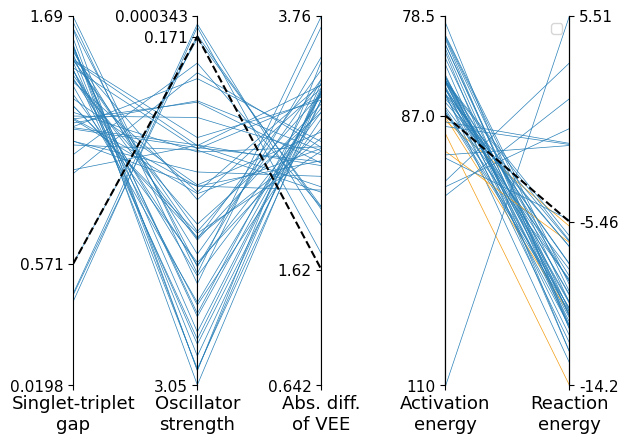

NMD


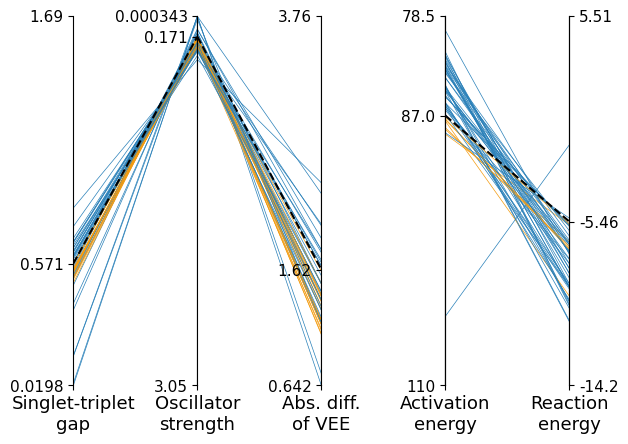

NMD-WS


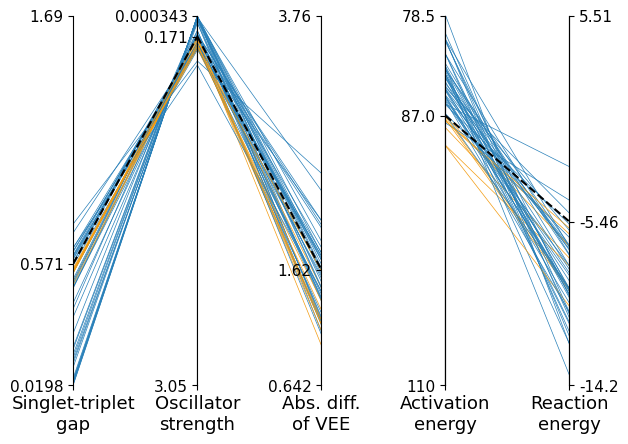

PIO


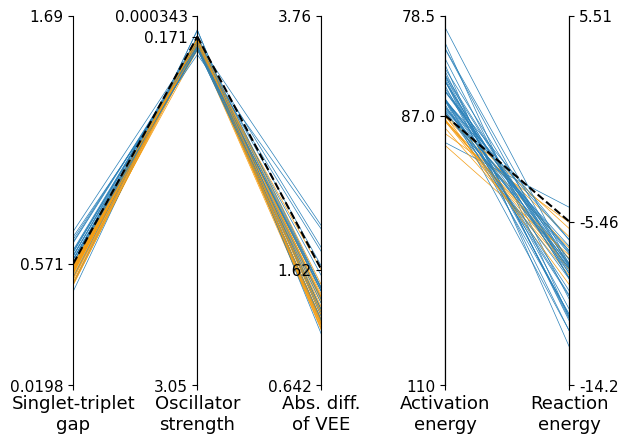

In [105]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random

def parallel_coordinates(data_sets, styles):
    new_feature_names = ['Singlet-triplet\ngap', 'Oscillator\nstrength', 
                     'Abs. diff.\nof VEE',
                     'Activation\nenergy', 'Reaction\nenergy']
    ylim_list = [(0.0198, 1.69), (-3.05, -0.000343), (0.642, 3.76), (-110, -78.5), (-14.2, 5.51)]
    dims = len(data_sets[0])
    x = range(dims)
    fig, axes = plt.subplots(1, dims-1, sharey=False)
    colors_first, colors_second = styles
    # Calculate the limits on the data
    min_max_range = list()
    for mn, mx in ylim_list:
        r = float(mx - mn)
        min_max_range.append((mn, mx, r))
    # Normalize the data sets
    norm_data_sets = list()
    for dimension, ds in enumerate(data_sets):
        nds = [(value - min_max_range[dimension][0]) / 
               min_max_range[dimension][2] 
               for dimension, value in enumerate(ds)]
        norm_data_sets.append(nds)
    data_sets = norm_data_sets
    # Plot the datasets on all the subplots
    for i, ax in enumerate(axes):
        for dsi, d in enumerate(data_sets):
            if i in [0, 1]:
                ax.plot([x[i], x[i+1]], [d[i], d[i+1]], colors_first[dsi], linewidth=0.5)
            elif i == 2:
                ax.plot([x[i], x[i+1]], [d[i], None], "white", linewidth=0.5)
            else:
                ax.plot([x[i], x[i+1]], [d[i], d[i+1]], colors_second[dsi], linewidth=0.5)
        ax.set_xlim([x[i], x[i+1]])
        ax.set_xticklabels([new_feature_names[i]], fontsize=13)

#     Plot the reference line
    ref_line = [0.571, -0.171, 1.62, -87.0, -5.46]
    norm_ref_line = [(value - min_max_range[dimension][0]) / 
                     min_max_range[dimension][2] 
                     for dimension, value in enumerate(ref_line)]
    for i, ax in enumerate(axes):
        if i == 2:
            ax.plot([x[i], x[i+1]], [norm_ref_line[i], None], 'k--')
        else:
            ax.plot([x[i], x[i+1]], [norm_ref_line[i], norm_ref_line[i+1]], 'k--')

    # Set the x axis ticks 
    for dimension, (axx, xx) in enumerate(zip(axes, x[:-1])):
        axx.xaxis.set_major_locator(ticker.FixedLocator([xx]))
        ticks = len(axx.get_yticklabels())
        labels = list()
        step = min_max_range[dimension][2] / (ticks - 1)
        mn = min_max_range[dimension][0]
        for i in range(ticks):
            v = mn + i * step
            labels.append('%4.2f' % v)
        axx.set_ylim(0, 1)
        axx.set_yticks([0, norm_ref_line[dimension], 1])
        if dimension in [0, 2]:
            axx.set_yticklabels([ylim_list[dimension][0], ref_line[dimension], ylim_list[dimension][1]], fontsize=11)
        else:
            axx.set_yticklabels([-ylim_list[dimension][0], -ref_line[dimension], -ylim_list[dimension][1]], fontsize=11)
        axx.spines['top'].set_visible(False)
        axx.spines['bottom'].set_visible(False)
        

    # Move the final axis' ticks to the right-hand side
    axx = plt.twinx(axes[-1])
    dimension += 1
    axx.xaxis.set_major_locator(ticker.FixedLocator(x[-1]))
    ticks = len(axx.get_yticklabels())
    step = min_max_range[dimension][2] / (ticks - 1)
    mn = min_max_range[dimension][0]
    axx.set_ylim(*ylim_list[-1])
    axx.set_yticks([ylim_list[-1][0], ref_line[-1], ylim_list[-1][1]])
    axx.set_yticklabels([ylim_list[-1][0], ref_line[-1], ylim_list[-1][1]], fontsize=11)
    axx.spines['top'].set_visible(False)
    axx.spines['bottom'].set_visible(False)
    # Stack the subplots 
    plt.subplots_adjust(wspace=0)

    return plt

name_dict = {"original data": "original data", "janus_scaler":"WS", "janus_hybrid":"NMD-WS",
                  "janus_uncertainty":"PIO", "janus_utopian":"NMD"}
for k, method in enumerate(["janus_scaler","janus_utopian", "janus_hybrid", "janus_uncertainty"]):

    data = combined_data_dict[method][["singlet-triplet value", "oscillator strength", "abs_diff_vee", "Ea", "Er"]].values
    data[:,1] = data[:,1]*(-1)
    data[:,3] = data[:,3]*(-1)

    colors_first = ["0"] * 50
    subdata = combined_data_dict[method]
    subdata_oe_pass = subdata[subdata["singlet-triplet value top%"] <= 15]
    subdata_oe_pass = subdata_oe_pass[subdata_oe_pass["oscillator strength top%"] <= 15]
    subdata_oe_pass = subdata_oe_pass[subdata_oe_pass["abs_diff_vee top%"] <= 15]
    subdata_oe_fail = subdata.drop(subdata_oe_pass.index)
    for idx in subdata_oe_pass.index:
        colors_first[idx] = "#F39C12"
    for idx in subdata_oe_fail.index:
        colors_first[idx] = "#2980B9"

    colors_second = ["0"] * 50
    subdata_rea_pass = subdata[subdata["Ea top%"] <= 15]
    subdata_rea_pass = subdata_rea_pass[subdata_rea_pass["Er top%"] <= 15]
    subdata_rea_fail = subdata.drop(subdata_rea_pass.index)
    for idx in subdata_rea_pass.index:
        colors_second[idx] = "#F39C12"
    for idx in subdata_rea_fail.index:
        colors_second[idx] = "#2980B9"

    pc = parallel_coordinates(data, styles=[colors_first, colors_second])
    new_feature_names = ['Singlet-triplet\ngap', 'Oscillator\nstrength', 
                         'Abs. diff. of vertical\nexcitation energy',
                         'Activation\nenergy', 'Reaction\nenergy']
    pc.xticks([0, 1, 2, 3, 4], new_feature_names)
    print(name_dict[method])
    if k == 0:
        plt.legend(["Successful", "Failed"])
    pc.savefig(f"{k+1}{name_dict[method]}.svg", format="svg", bbox_inches='tight')
    pc.show()
